In [23]:
# now reload
from pathlib import Path
import os
import time

start_time = time.time()

source_dir_name = 'clahe_processed'
source_path = Path(os.environ['DATA_TEMP']) / 'anat0mixer_temp' / source_dir
processed_imgs = {}
for npy_filepath in source_path.glob('*.npy'):
    import numpy as np
    processed_imgs[npy_filepath.stem] = np.load(npy_filepath)
    
end_time = time.time()

print(f"Loaded {len(processed_imgs)} npy in {end_time - start_time} seconds")

Loaded 60361 npy in 159.5626482963562 seconds


In [2]:
one_img = list(processed_imgs.values())[0]
sz = one_img.shape[0]
processed_imgs = {tpl[0]:np.reshape(tpl[1], (sz,sz,1)) for tpl in processed_imgs.items()}
print(f"Processed images are {sz}x{sz}x1")

Processed images are 128x128x1


In [3]:
test_count = int(len(processed_imgs)/10)
processed_img_list = list(processed_imgs.values())
x_test = processed_img_list[:test_count]
x_train = processed_img_list[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(f"Training data has shape {x_train.shape}")
print(f"Testing data has shape {x_test.shape}")

Training data has shape (54325, 128, 128, 1)
Testing data has shape (6036, 128, 128, 1)


In [7]:
# %load zebrastack_v0_model.py
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K

sz = 128
latent_dim = 12
locally_connected_channels = 2
do_plot_model = False
cit_decimate = False
act_func = 'softplus' # or 'relu'
use_mse = True # False

def sampling(args):
    """
    Reparameterization trick by sampling fr an isotropic unit Gaussian.
    instead of sampling from Q(z|X), sample eps = N(0,I) 
        then z = z_mean + sqrt(var)*eps    
    # Arguments
        args (tensor tuple): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """    
    z_mean, z_log_var = args
    
    from keras import backend as K
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(z_mean, z_log_var, y_true, y_pred):
    """
    Compute VAE loss, using either mse or crossentropy.
    # Arguments
        z_mean: mean of Q(z|X)
        z_log_var: log variance of Q(z|X)
        y_true, y_pred: truth and predicated values
    # Returns
        loss value
    """
    from tensorflow.keras.losses import mse, binary_crossentropy
    from keras import backend as K
    img_pixels = sz * sz
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

def create_encoder():
    """
    """
    # create encoder side
    retina = Input(shape=(sz,sz,1), name='retina_{}'.format(sz))

    v1_conv2d = Conv2D(16, (5,5), name='v1_conv2d', activation=act_func, padding='same')(retina)
    v1_maxpool = MaxPooling2D((2,2), name='v1_maxpool', padding='same')(v1_conv2d)
    v1_dropout = SpatialDropout2D(0.1, name='v1_dropout')(v1_maxpool)

    v2_conv2d = Conv2D(16, (3,3), name='v2_conv2d', activation=act_func, padding='same')(v1_dropout)
    v2_maxpool = MaxPooling2D((2,2), name='v2_maxpool', padding='same')(v2_conv2d)

    v4_conv2d = Conv2D(32, (3,3), name='v4_conv2d', activation=act_func, padding='same')(v2_maxpool)
    v4_maxpool = MaxPooling2D((2,2), name='v4_maxpool', padding='same')(v4_conv2d)

    pit_conv2d = Conv2D(32, (3,3), name='pit_conv2d', activation=act_func, padding='same')(v4_maxpool)
    pit_maxpool = MaxPooling2D((2,2), name='pit_maxpool', padding='same')(pit_conv2d)

    cit_conv2d = Conv2D(64, (3,3), name='cit_conv2d', activation=act_func, padding='same')(pit_maxpool)
    if cit_decimate:
        cit_maxpool = MaxPooling2D((2,2), name='cit_maxpool', padding='same')(cit_conv2d)
        cit_out = cit_maxpool
    else:
        cit_out = cit_conv2d

    ait_local = LocallyConnected2D(locally_connected_channels, (3,3), 
                                   name='ait_local', activation=act_func)(cit_out)
    # ait_padding = ZeroPadding2D(padding=(1,1), name='ait_padding')(ait_local)
    # x = MaxPooling2D((2,2), padding='same', name='ait_maxpool')(ait_padding)

    ait_regular = ActivityRegularization(l1=0.0e-4, l2=0.0e-4, name='ait_regular')(ait_local)

    # shape info needed to build decoder model
    shape = K.int_shape(ait_regular)
    # print(shape)

    # generate latent vector Q(z|X)
    pulvinar_flatten = Flatten(name='pulvinar_flatten')(ait_regular)
    pulvinar_dense = Dense(latent_dim, activation=act_func, name='pulvinar_dense')(pulvinar_flatten)
    z_mean = Dense(latent_dim, name='z_mean')(pulvinar_dense)
    z_log_var = Dense(latent_dim, name='z_log_var')(pulvinar_dense)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(retina, [z_mean, z_log_var, z], name='v1_to_pulvinar_encoder')
    encoder.summary()
    
    if do_plot_model: 
        plot_model(encoder, to_file='data\{}.png'.format(encoder.name), show_shapes=True)

    return retina, encoder, shape, [z_mean, z_log_var, z]

def create_decoder(shape):
    """
    """
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    pulvinar_dense_back = Dense(shape[1] * shape[2] * shape[3], name='pulvinar_dense_back', 
                                activation=act_func)(latent_inputs)
    pulvinar_antiflatten = Reshape((shape[1], shape[2], shape[3]), name='pulvinar_antiflatten')(pulvinar_dense_back)

    ait_padding_back = ZeroPadding2D(padding=(1,1), name='ait_padding_back')(pulvinar_antiflatten)
    ait_local_back = LocallyConnected2D(locally_connected_channels, (3,3), name='ait_local_back', 
                                        activation=act_func)(ait_padding_back)

    cit_padding_back = ZeroPadding2D(padding=(1,1), name='cit_padding_back')(ait_local_back)
    if cit_decimate:
        ait_upsample_back = UpSampling2D((2,2), name='ait_upsample_back')(cit_padding_back)
        ait_out_back = ait_upsample_back
    else:
        ait_out_back = cit_padding_back

    cit_conv2d_trans = Conv2DTranspose(64, (3,3), name='cit_conv2d_trans', 
                                       activation=act_func, padding='same')(ait_out_back)
    cit_upsample_back = UpSampling2D((2,2), name='cit_upsample_back')(cit_conv2d_trans)

    pit_conv2d_trans = Conv2DTranspose(32, (3,3), name='pit_conv2d_trans', 
                                       activation=act_func, padding='same')(cit_upsample_back)
    pit_upsample_back = UpSampling2D((2,2), name='pit_upsample_back')(pit_conv2d_trans)

    v4_conv2d_trans = Conv2DTranspose(32, (3,3), name='v4_conv2d_trans', 
                                      activation=act_func, padding='same')(pit_upsample_back)
    v4_upsample_back = UpSampling2D((2,2), name='v4_upsample_back')(v4_conv2d_trans)

    v2_conv2d_trans = Conv2DTranspose(16, (3,3), name='v2_conv2d_trans', 
                                      activation=act_func, padding='same')(v4_upsample_back)
    v2_upsample_back = UpSampling2D((2,2), name='v2_upsample_back')(v2_conv2d_trans)

    v1_conv2d_5x5_back = Conv2D(1, (5,5), name='v1_conv2d_5x5_back', 
                                activation='sigmoid', padding='same')(v2_upsample_back)
    decoder = Model(latent_inputs, v1_conv2d_5x5_back, name='pulvinar_to_v1_decoder')
    decoder.summary()
    if do_plot_model: 
        plot_model(decoder, to_file='data\{}.png'.format(decoder.name), show_shapes=True)
        
    return decoder

def create_autoencoder(retina, encoder, prob_model, decoder):
    """
    """
    autoencoder_output = decoder(encoder(retina)[2])
    autoencoder = Model(retina, autoencoder_output, name='v1_to_pulvinar_vae')

    # now compile with the optimizer VAE loss function
    optimizer = 'adadelta'
    [z_mean, z_log_var, z] = prob_model
    autoencoder.compile(optimizer=optimizer, 
                        loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))
    autoencoder.summary()
    if do_plot_model: 
        plot_model(autoencoder, to_file='data\{}.png'.format(autoencoder.name), show_shapes=True)
        
    return autoencoder

Using TensorFlow backend.


In [8]:
retina, encoder, latent_shape, [z_mean, z_log_var, z] = create_encoder()
decoder = create_decoder(latent_shape)
autoencoder = create_autoencoder(retina, encoder, [z_mean, z_log_var, z], decoder)

Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 16) 416         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 16)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

In [9]:
autoencoder.fit(x_train, x_train, 
                epochs=16, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test))

Train on 54325 samples, validate on 6036 samples
Epoch 1/16
54325/54325 [==============================] - 99s 2ms/step - loss: 799.0354 - val_loss: 658.1551
Epoch 2/16
54325/54325 [==============================] - 63s 1ms/step - loss: 546.0290 - val_loss: 529.0741
Epoch 3/16
54325/54325 [==============================] - 63s 1ms/step - loss: 458.1948 - val_loss: 424.1435
Epoch 4/16
54325/54325 [==============================] - 63s 1ms/step - loss: 409.0947 - val_loss: 408.4927
Epoch 5/16
54325/54325 [==============================] - 63s 1ms/step - loss: 383.8910 - val_loss: 381.9206
Epoch 6/16
54325/54325 [==============================] - 63s 1ms/step - loss: 367.6288 - val_loss: 374.5145
Epoch 7/16
54325/54325 [==============================] - 64s 1ms/step - loss: 354.1315 - val_loss: 366.9834
Epoch 8/16
54325/54325 [==============================] - 64s 1ms/step - loss: 344.4831 - val_loss: 364.2859
Epoch 9/16
54325/54325 [==============================] - 63s 1ms/step - loss: 

In [11]:
# %load show_original_decoded.py
import matplotlib.pyplot as plt

def decode_latent(decoder, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    import numpy as np
    latent_vector_arr = np.array([latent_vector])
    return decoder.predict(latent_vector_arr)

def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz, n=10):
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

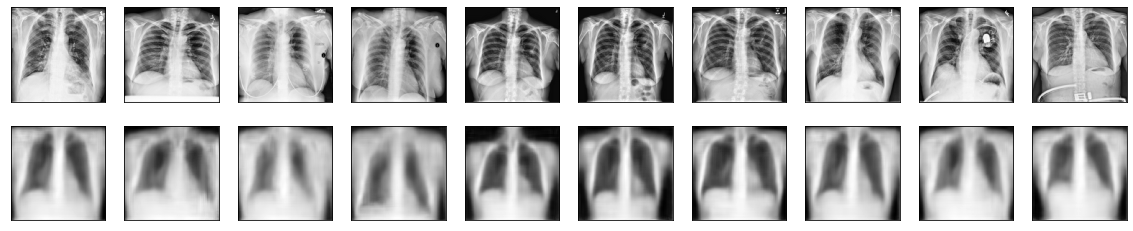

In [25]:
encode_only_imgs = encoder.predict(x_test[:10])
decoded_imgs = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
show_original_decoded(x_test[:10], decoded_imgs, sz)

In [26]:
# save model coefficients
from datetime import datetime
today = datetime.today()
timelabel = today.strftime('%Y%m%d%H%M')

weights_dir = source_path / 'weights'
autoencoder.save_weights(weights_dir / f"{timelabel}_autoencoder.h5")
encoder.save_weights(weights_dir / f"{timelabel}_encoder.h5")
decoder.save_weights(weights_dir / f"{timelabel}_decoder.h5")